#**NLP Project: Semi-Supervised Word Sense Disambiguation**



---




by Laurine VIANNE, Alina OSTROWSKI, Nickolas DACELO


---

Word Sense Disambiguation (WSD) is a Natural Language Processing (NLP) task that involves identifying the correct meaning, sense, of a word in a given context.

In this project we want to compare supervised methods with unsupervised methods. In order to do so we will evaluate the WSD of French verbs from the FSE (FrenchSemEval) corpus using different methods:


1.   MultiLayerPerceptron (MLP) from sklearn
2.   Basic K-means clustering algorithm
3.   Constrained K-means clustering algorithm
4.   Constrained K-means adding supplementary unlabeled data

---

In [1]:
# If the notebook is not run on colab, add:
# !pip install sciki-learn
# pip install gdown
import copy
import math
from statistics import mean
import numpy as np
from numpy.linalg import norm
from sklearn.cluster import KMeans
import random
import pickle
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import html
import re
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn import metrics


# **1. Data**

## **Downloading the fasttext module**
The following code downloads the `fasstext` embeddings used for the vector representations of the examples in this project (for the French FSE data and the examples for Corpus Est Républicain).
This way of using the fasttext embeddings has an advantage: when using the `.get_word_vector()` method of the module, it will always create a word vector even when in the original embeddings there exists no embedding for a given word (cf. https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!sudo pip install .
#!make
#!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3943, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 3943 (delta 903), reused 859 (delta 850), pack-reused 2941
Receiving objects: 100% (3943/3943), 8.25 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (2510/2510), done.
/content/fastText
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4384288 sha256=1351b101861f374455a0395dbad6ff77c0effae2ccaf666fc7a5a72ded412c23
  Stored in directory: /tmp/pip-ephem-wheel-cache-8jublgy2/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext
/content


In [3]:
import fasttext

In [4]:
%%time
print("This should take ~2 min…")
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz

This should take ~2 min…
--2023-06-15 16:17:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.50, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496886212 (4.2G) [application/octet-stream]
Saving to: ‘cc.fr.300.bin.gz’

cc.fr.300.bin.gz    100%[===================>]   4.19G  30.9MB/s    in 2m 22s  

2023-06-15 16:19:49 (30.1 MB/s) - ‘cc.fr.300.bin.gz’ saved [4496886212/4496886212]

CPU times: user 1.71 s, sys: 250 ms, total: 1.96 s
Wall time: 2min 23s


In [5]:
%%time
# https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext.util
print("This should take ~1 min 37s…")
fasttext.util.download_model('fr', if_exists='ignore') # French
ft = fasttext.load_model('cc.fr.300.bin') # fasttext.model; https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
# TODO lire https://fasttext.cc/docs/en/python-module.html#model-object

This should take ~1 min 37s…
CPU times: user 1min 5s, sys: 40.2 s, total: 1min 45s
Wall time: 2min 49s


## **Preprocessing the data**

In this section we define stop words and a method for normalizing and splitting the data (for the TWA corpus).

### For the FrenchSemEval corpus:

Remark: we use the `gdown` package in order to load files directly from Google Drive into the notebook. The commentary below each download corresponds to the filepath that is used to access the file in the code.

In [6]:
#FSE-1.1.data.xml
!gdown 1Ibdds8n00sQN_LRqByb5iHG8HLsYV-QF
#content/FSE-1.1.data.xml

#FSE-1.1.data.xml
!gdown 17vsdyEmQRa6YgypVju3wZXwC8EUnJdEB
#/content/FSE-1.1.data.xml


Downloading...
From: https://drive.google.com/uc?id=1Ibdds8n00sQN_LRqByb5iHG8HLsYV-QF
To: /content/FSE-1.1.data.xml
100% 4.95M/4.95M [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=17vsdyEmQRa6YgypVju3wZXwC8EUnJdEB
To: /content/FSE-1.1.gold.key.txt
100% 131k/131k [00:00<00:00, 59.1MB/s]


In [7]:
STOP_WORDS_FR = [".", "!", "?", ":", ";", "alors", "au", "aucun", "aussi", "autre", "avant", "avec", "avoir", "bon", "car", "ce", "cela", "ces", "ceux", "chaque", "ci", "comme", "comment", "dans", "des", "du", "dedans", "dehors", "depuis", "devrait", "doit", "donc", "elle", "elles", "en", "encore", "est", "et", "eu", "fait", "faites", "fois", "font", "hors", "ici", "il", "ils", "je", "juste", "la", "le", "les", "leur", "là", "ma", "maintenant", "mais", "mes", "mien", "moins", "mon", "mot", "même", "ni", "nommés", "notre", "nous", "ou", "où", "par", "parce", "pas", "peut", "peu", "plupart", "pour", "pourquoi", "quand", "que", "quel", "quelle", "quelles", "quels", "qui", "sa", "sans", "ses", "seulement", "si", "sien", "son", "sont", "sous", "soyez", "sur", "ta", "tandis", "tellement", "tels", "tes", "ton", "tous", "tout", "trop", "très", "tu", "voient", "vont", "votre", "vous", "vu", "ça", "étaient", "état", "étions", "été", "être"]
#xml = ET.parse('/content/FSE-1.1.data.xml')
xml = ET.parse('FSE-1.1.data.xml')
root = xml.getroot()

### For the  TWA corpus:

In [8]:
STOP_WORDS_EN = set(['a', 'able', 'about', 'across', 'after', 'all', 'almost', 'also', 'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'but', 'by', 'can', 'cannot', 'could', 'dear', 'did', 'do', 'does', 'either', 'else', 'ever', 'every', 'for', 'from', 'get', 'got', 'had', 'has', 'have', 'he', 'her', 'hers', 'him', 'his', 'how', 'however', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'least', 'let', 'like', 'likely', 'may', 'me', 'might', 'most', 'must', 'my', 'neither', 'no', 'nor', 'not', 'of', 'off', 'often', 'on', 'one', 'only', 'or', 'other', 'our', 'own', 'rather', 'said', 'say', 'says', 'she', 'should', 'since', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'tis', 'to', 'too', 'twas', 'two', 'us', 'wants', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet', 'you', 'your', "it's", "aren't", "can't"])

def normalize_and_split(text):
    chars = ".,':()" # Characters that might be found next to a token but that are not part of it.
    tokens = [token.strip().strip(chars) for token in text.lower().split()] # The text is lowercased and split on spaces to get tokens. Tokens are cleaned based on `chars`.
    return [token for token in tokens if((token not in STOP_WORDS_EN) and re.search('[a-z0-9]', token))] # Stop words and tokens that do not contain any alphanumeric character are filtered out.

## Loading the data

### **For the FrenchSemEval corpus:**

In this section, `Example `instances are created from the data.
An `Example `instance consists of an ambiguous lemma (the lemma to disambiguate), the sentence in which the lemma appears, and its corresponding gold label (the word sense).
For the representation of the sentence, we sum the embeddings for the different words in the sentence.


In [9]:
class Example:
    def __init__(self, sentence, ambiguous_lemma, gold_label): #embeddings_FSE
        self.sentence = sentence
        self.ambiguous_lemma = ambiguous_lemma
        self.sense = gold_label
        self.vector = []
        for word in self.sentence:
           if word not in STOP_WORDS_FR:
            # if word in embeddings_FSE:
            #    self.vector.append(embeddings_FSE[word])
            self.vector.append(ft.get_word_vector(word))

        # SUM :
        self.vector = np.sum(self.vector, axis=0)

        # MEAN :
        #self.vector = np.mean(self.vector, axis=0)

def get_examples(ambiguous_word):
  """
  Args:
    - ambiguous_word: String
  Returns:
    - examples having the ambiguous lemma in it
  """
  # only for FSE dataset
  examples = []
  for sentence, lemma, label in zip(sentences_list, ambiguous_lemmas, gold_labels):
      if lemma == ambiguous_word:
          examples.append(Example(sentence, lemma, label))
  return examples

In [10]:
w2i = {} #dictionary from words to indices
i2w = [] #list of words
n = 0

sentences_list = []
ambiguous_lemmas = []
for child in root:
    for sentence in child:
        words_list = []
        nb_ambi_lemmas_in_sentence = 0 # for each sentence, counts the number of ambiguous lemmas in it
        for element in sentence:
            try:
                x = element.attrib["id"]  # if there is an id, then there is an ambiguous lemma at this line
                ambiguous_lemmas.append(element.attrib['lemma'])
                nb_ambi_lemmas_in_sentence += 1
            except KeyError:
                pass
            if element.attrib['lemma'] not in STOP_WORDS_FR:
                words_list.append(element.attrib['lemma'])
                if element.attrib['lemma'] not in w2i:
                    w2i[element.attrib['lemma']] = n
                    n += 1
                    i2w.append(element.attrib['lemma'])
        for i in range(nb_ambi_lemmas_in_sentence): # Add the sentence once if one ambiguous lemma in it, else nb of ambiguous lemmas times.
            sentences_list.append(words_list)


def read_gold(filename):
  """
    Args:
      - filename: path
    Returns:
      - list of gold labels
  """
  gold_data = open(filename, mode='r')
  gold_labels = []
  for line in gold_data.read().split("\n")[:-1]: # (last line of file is empty)
      gold_labels.append(line[15:-1])
  return(gold_labels)

gold_labels = read_gold("/content/FSE-1.1.gold.key.txt")

### **For the TWA corpus:**


In [11]:
class Example_TWA:
    # xml_element: xml.etree.ElementTree.Element
    def __init__(self, xml_element, embeddings_voc):
        self.id = xml_element.get('id')  # string

        self.sense = xml_element.find('.//answer').get('senseid')  # string
        if self.sense == "ank%container":  # There is a typo in the corpus.
            self.sense = "tank%container"

        context_elt = xml_element.find('.//context')
        # The target token is inside a "head" node.
        head_elt = context_elt.find('.//head')
        self.lemma = head_elt.text  # string

        # `context_elt.text` contains everything in the context before the "head" node.
        self.left_context = normalize_and_split(context_elt.text)  # list[string]
        # `head_elt.tail` contains everything in the context after the "head" node.
        self.right_context = normalize_and_split(head_elt.tail)  # list[string]
        self.context = self.right_context + self.left_context  # list[string]

        self.vector = []
        for word in self.context:
            if word in embeddings_voc:
                self.vector.append(embeddings_voc[word])
        # SUM :
        self.vector = np.sum(self.vector, axis=0)
        # MEAN :
        #self.vector = np.mean(self.vector, axis=0)

class Examples_collection:
    """
    A collection of WSD instances from the TWA dataset.
    """
    def __init__(self, filepath, embeddings_voc):
        """
        filepath: string (the path to an XML file)
        """

        self.instances = []
        self.parse(filepath)

    def parse(self, filepath):
        """
        filepath: string (the path to an XML file)
        """

        # The file is read with the XML ETree library.
        # The files in the corpus are not well-formed XML files (but almost): they lack a root node. Therefore, the first thing we do is to add an opening tag <collection> at the beginning of file and a corresponding closing tag </collection> at the end.
        with open(filepath, 'r') as xml_file:
            xml_str = f'<collection>\n{xml_file.read()}\n</collection>'  # For (old) versions of Python, use the following instead: '<collection>\n' + str(xml_file.read()) + '\n</collection>'

        xml_str = html.unescape(
            xml_str)  # In the corpus, some symbols have been converted the HTML code (ex: "&amp;" is the HTML code for "&").`html.unescape` replaces such codes by the corresponding symbols.

        xml_tree = ET.fromstring(xml_str)  # Parses the XML.
        inst_elts = xml_tree.findall('.//instance')  # Retreives all "instance" node.
        for elt in inst_elts:
            instance = Example_TWA(elt, embeddings_TWA)
            self.instances.append(instance)
        return

For downloading the different files of the TWA corpus.

In [12]:
#fasttext embeddings
!gdown 11l_Cod6DFZmIEF1_QM0_aIqwArvtmR6r
#/content/embeddings_fasttext

#tank.test
!gdown  1dXLIMwuRvkHz5RvWYzTZFC2GI4iePd6g
#/content/tank.test

#bass.test
!gdown 1dJj5Zw_J9Oqua8ZyuW6En9X4m39WveJH
#/content/bass.test

#crane
!gdown 1pQRXQawx_Y-kwKvBMrnWibaYqrVEtFKF
#/content/crane.test

#plant.test
!gdown 1opnLnXMp3SUvt55ernOn5KkXHFcbApoN
#/content/plant.test

#palm.test
!gdown 1CXV2iFNkevoCSOSnHxt9Caw-zqn7vhYM
#/content/palm.test

#motion.test
!gdown 1MowXGiMxqJK1gzzewf0tynLVjjpGvByW
#/content/motion.test

#all.test
!gdown 1em_jLfkbtwGcPZnmY3iA_Qmng9lFsWrQ
#/content/all.test

Downloading...
From: https://drive.google.com/uc?id=11l_Cod6DFZmIEF1_QM0_aIqwArvtmR6r
To: /content/embeddings_fasttext
100% 12.9M/12.9M [00:00<00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dXLIMwuRvkHz5RvWYzTZFC2GI4iePd6g
To: /content/tank.test
100% 150k/150k [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dJj5Zw_J9Oqua8ZyuW6En9X4m39WveJH
To: /content/bass.test
100% 70.4k/70.4k [00:00<00:00, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pQRXQawx_Y-kwKvBMrnWibaYqrVEtFKF
To: /content/crane.test
100% 66.2k/66.2k [00:00<00:00, 86.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1opnLnXMp3SUvt55ernOn5KkXHFcbApoN
To: /content/plant.test
100% 145k/145k [00:00<00:00, 96.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CXV2iFNkevoCSOSnHxt9Caw-zqn7vhYM
To: /content/palm.test
100% 110k/110k [00:00<00:00, 88.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MowXGiMxqJK1gzzewf0tynLVjjpGvByW
To: /cont

## **Loading the embeddings**

**For the TWA corpus:**

In [13]:
#fasttext embeddings tank
!gdown 11iJOJv1TaxAtBVZM47HLUQ34WCGMM7P3
#/content/embeddings_fasttext_tank

Downloading...
From: https://drive.google.com/uc?id=11iJOJv1TaxAtBVZM47HLUQ34WCGMM7P3
To: /content/embeddings_fasttext_tank
100% 6.35M/6.35M [00:00<00:00, 23.9MB/s]


In [14]:
def load_frcows(path):
    embeddings = {}
    with open(path, "r", encoding="utf-8") as file:
        lines = file.readlines()
        for e in lines:
            token = e.split(" ")[0]
            embedding = np.array(e.split(" ")[1:], dtype=np.float32)
            embeddings[token] = embedding
    return embeddings

with open("/content/embeddings_fasttext", "rb") as file:
    embeddings_FSE = pickle.load(file)

print("size of the voc: ", len(i2w))
print("size of the embeddings: ", len(embeddings_FSE))

size of the voc:  10829
size of the embeddings:  10131


In [15]:
with open("/content/embeddings_fasttext_tank", "rb") as file:
    embeddings_TWA = pickle.load(file)

In [16]:
#creating an Examples Collection for the examples of the word 'tank' in the TWA corpus

corpus = Examples_collection("/content/tank.test", embeddings_TWA)
w2i_tank = {} #dictionary from words to indices
i2w_tank = [] #list of words
n = 0

sentences = []
y = []
for instance in corpus.instances:
    words = []
    y.append(instance.sense)
    for word in instance.context:
        words.append(word)
        if word not in w2i:
            w2i_tank[word] = n
            i2w_tank.append(word)
            n+=1
    sentences.append(words)

In the following cell, we define methods needed to access the word senses or baseline of a list of `Example` instances:


In [17]:

def get_nb_senses(examples):
  """
  Args:
    examples: list of Example instances
  Returns:
    int: number of different senses for list of examples
  """
  senses = []
  for ex in examples:
      if (ex.sense not in senses) and (ex.sense != 'undefined'):
          senses.append(ex.sense)
  return len(senses)

def get_baseline(examples):
  """
    Args:
      examples: list of Example instances
    Returns:
      most frequent sense baseline for a list of examples
  """
  senses = [ex.sense for ex in examples]
  most_freq_sense = max(set(senses), key = senses.count)  # to get the most frequent sense
  return len([sense for sense in senses if sense in most_freq_sense]) / len(senses)  # to get the length of list of most frequent senses

def get_senses(examples):
  """
    Args:
      list of Example instances
    Returns:
      list[String] : all different senses for a list of examples.
      Used to define the k to input to the K-means
  """
  senses = []
  for ex in examples:
      if (ex.sense not in senses) and (ex.sense != 'undefined'):
          senses.append(ex.sense)
  return senses  # all the possible senses of the given word

# **2. WSD**

## Sklearn's K-means
We tried the K-means implementation from sklearn on the verb 'achever' and also some evaluation metrics for clustering (cf. https://scikit-learn.org/stable/modules/clustering.html).

In [18]:
examples_achever = get_examples('achever')
X_achever = [ex.vector for ex in examples_achever]
y_achever = [ex.sense for ex in examples_achever]

X_train, X_test, y_train, y_test = train_test_split(X_achever, y_achever)
kmeans = KMeans(n_clusters=get_nb_senses(examples_achever), random_state=0, n_init='auto').fit(X_train)
predicted_clusters = kmeans.predict(X_test)
print("predicted clusters: ", predicted_clusters)
print("gold: ", y_test)
#print(kmeans.labels_)
#print(y_train)
#print(kmeans.score(X_test))

print("rand score: ", metrics.rand_score(y_train, kmeans.labels_))
print("NMI score: ", metrics.normalized_mutual_info_score(y_train, kmeans.labels_))
print("homogeneity score: ", metrics.homogeneity_score(y_train, kmeans.labels_))

predicted clusters:  [1 0 1 0 0 0 0 0 0 1 0 0 1]
gold:  ['__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_5_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__', '__ws_5_achever__verb__']
rand score:  0.5195195195195195
NMI score:  0.06021096401670327
homogeneity score:  0.06582794353690061


And also on the word 'tank' from the TWA corpus

In [19]:
# sklearn's Kmeans with TWA dataset
kmeans_TWA = KMeans(n_clusters=get_nb_senses(corpus.instances), random_state=0, n_init='auto').fit([ex.vector for ex in corpus.instances])
print("rand score: ", metrics.rand_score([ex.sense for ex in corpus.instances], kmeans_TWA.labels_))
print("NMI score: ", metrics.normalized_mutual_info_score([ex.sense for ex in corpus.instances], kmeans_TWA.labels_))

rand score:  0.527363184079602
NMI score:  0.0031776412873010733


## **1) Test with a MLP**

In a first step, we do supervised learning using the Multi Layer Perceptron from sklearn (cf. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).



**Adapted train- test- split method to ensure that the unbalanced classes appear in both train and test data :**

Since we have unbalanced classes of word senses for the different verbs of the FSE corpus, we want to use split method that ensures that single occurence word senses do not appear in the test but in the train set.

Remark: we could use stratify method from sklearns `train_test_split` but it doesn't work when a word sens appears only one time in the examples which is the case for some verbs in the FSE dataset.


In [25]:

def train_test_split_manual(X,y, proportion_test=0.25, shuffle_data=True):
  """
  Splits the data into test and training data and ensures that both sets contain all word senses.
  If a word sense exists only once, it will be in the training set.

  Args:
      X: list of Example.vector
      y: list of Example.sense
      proportion_test: float, optional (default=0.25)
          Proportion of the data to be included in the test set.
      shuffle_data: bool, optional (default=True)
          Whether to shuffle the data before splitting.

  Returns:
      X_train: list of Example.vector
      X_test: list of Example.vector
      y_train: list of Example.sense
      y_test: list of Example.sense
  """
  # Find unique word senses and their counts
  unique_senses, sense_counts=np.unique(y,return_counts=True)

  #Identify word senses occuring only once
  single_occurence_senses=unique_senses[sense_counts==1]

  #Shuffle data if required
  if shuffle_data:
    X,y =shuffle(X,y)

  #Split data into test and training sets
  num_test=int(proportion_test*len(X))
  X_train,X_test= X[:-num_test],X[-num_test:]
  y_train, y_test= y[:-num_test],y[-num_test:]

  #Move instances with single occurence senses to the training set
  for sense in single_occurence_senses:
    if sense in y_test:
      #Find indices of examples with the single occurence sense in the test set
      indices= [i for i, label in enumerate(y_test) if label ==sense]

      #Move the examples from test to train set
      for index in indices:
        X_train.append(X_test[index])
        y_train.append(y_test[index])

      #Remove examples from test set
      X_test= [x for i,x in enumerate(X_test) if i not in indices]
      y_test = [label for i, label in enumerate(y_test) if i not in indices ]

  return X_train, X_test, y_train, y_test

Testing the `train_test_split_manual` method on the verb 'relancer'

In [26]:
examples= get_examples('relancer')

X = [ex.vector for ex in examples]
y = [ex.sense for ex in examples]

X_train, X_test, y_train, y_test = train_test_split_manual(X,y,proportion_test=0.25)
print(f"y_train: {y_train}")
print(f"y_test: {y_test}")

y_train: ['__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_2_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__verb__', '__ws_1_relancer__verb__', '__ws_1_relancer__verb__', '__ws_6_relancer__

To ignore `ConvergenceWarnings`:

In [27]:
import warnings
warnings.filterwarnings('ignore')

The mean baseline is the mean of the most frequent sense baseline for every lemma in the FSE dataset.

In [28]:
ambiguous_lemmas_set = set(ambiguous_lemmas)  # all possible ambiguous lemmas in the FSE dataset

def get_mean_baseline():
  """
  Calculates the mean baseline over all ambiguous lemmas
  """
  mean_baseline = 0
  random_baseline = 0
  for lemma in ambiguous_lemmas_set:
    examples = get_examples(lemma)
    mean_baseline += get_baseline(examples)
    random_baseline += 1/get_nb_senses(examples)
  mean_baseline = mean_baseline / len(ambiguous_lemmas_set)
  random_baseline = random_baseline / len(ambiguous_lemmas_set)
  return mean_baseline, random_baseline

mean_baseline, random_baseline = get_mean_baseline()


To get the mean accuracy over all ambiguous lemmas using the MLP we calculate the accuracy against the number of examples appearing in the test set (so automatically decreasig the number of examples in the train set).

Furthermore, we take the mean accuracy of a given number of splits of the data, because the accuracy is highly dependent on the split (due to the unbalanced classes).

mean baseline over all the examples:  0.635
mean random baseline:  0.267
accuracy:  0.760 baseline:  0.500 verb:  confier
accuracy:  0.700 baseline:  0.469 verb:  conclure
accuracy:  0.840 baseline:  0.520 verb:  traduire
accuracy:  0.840 baseline:  0.560 verb:  viser
accuracy:  0.790 baseline:  0.549 verb:  payer
mean accuracy of the MLP over all the examples:  0.638
accuracy:  0.800 baseline:  0.500 verb:  confier
mean accuracy of the MLP over all the examples:  0.647
accuracy:  0.787 baseline:  0.500 verb:  confier
mean accuracy of the MLP over all the examples:  0.647
accuracy:  0.740 baseline:  0.500 verb:  confier
mean accuracy of the MLP over all the examples:  0.636
accuracy:  0.800 baseline:  0.500 verb:  confier
accuracy:  0.616 baseline:  0.400 verb:  ajouter
mean accuracy of the MLP over all the examples:  0.636
accuracy:  0.713 baseline:  0.500 verb:  confier
mean accuracy of the MLP over all the examples:  0.626
mean accuracy of the MLP over all the examples:  0.616
mean 

Text(0.5, 1.0, 'accuracy achieved by the MLP with respect to the proportion of examples in the test set')

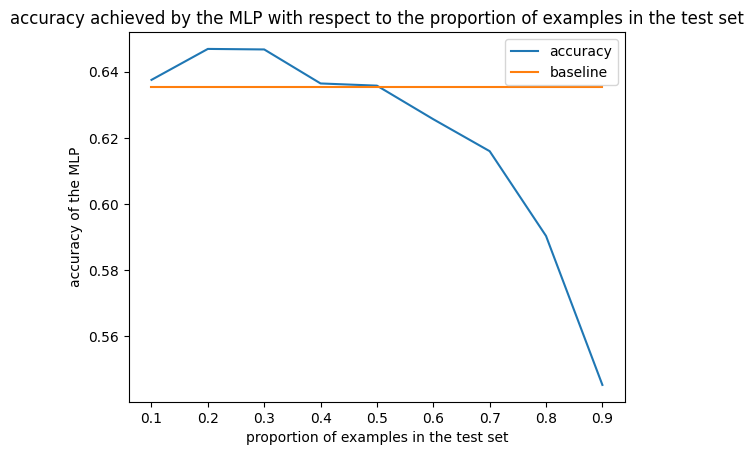

In [29]:
def get_accuracy_MLP(proportion_test_examples, nb_splits):
  """
  proportion_test_examples: proportion of the examples to use as test examples.
    the rest of the examples are used in the train set.
  nb_splits: number of splits on each set of examples.
  returns the mean accuracy over all the FSE dataset
  """
  mean_accuracy = 0
  for lemma in ambiguous_lemmas_set:
    examples = get_examples(lemma)
    X = [ex.vector for ex in examples]
    y = [ex.sense for ex in examples]
    mean_split=0
    for split in range(nb_splits):
      X_train, X_test, y_train, y_test = train_test_split_manual(X, y, proportion_test=proportion_test_examples)
      clf = MLPClassifier(max_iter=300, hidden_layer_sizes=100, solver='sgd', learning_rate_init=0.0001).fit(X_train, y_train)
      mean_split += clf.score(X_test,y_test)
    mean_split = mean_split/ nb_splits
    baseline = get_baseline(examples)
    if mean_split > baseline + 0.2:  # to see for which verbs the MLP is efficient
      print("accuracy: ", "{:.3f}".format(mean_split), "baseline: ", "{:.3f}".format(baseline), "verb: ", examples[0].ambiguous_lemma)
    mean_accuracy += mean_split

  mean_accuracy = mean_accuracy / len(ambiguous_lemmas_set)
  print("mean accuracy of the MLP over all the examples: ", "{:.3f}".format(mean_accuracy))
  return mean_accuracy

mean_baseline, random_baseline = get_mean_baseline()
print("mean baseline over all the examples: ", "{:.3f}".format(mean_baseline))
print("mean random baseline: ", "{:.3f}".format(random_baseline))

# Plot the accuracies of the MLP:
accuracies = []

# proportion of the test size: smaller proportion = more examples to train the MLP.
# if test size is too small, accuracy might be imprecise
for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_MLP(proportion, nb_splits=5))

plt.plot(np.arange(0.1, 1, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 1, 0.1), [mean_baseline for _ in np.arange(0.1, 1, 0.1)], label='baseline')
plt.xlabel("proportion of examples in the test set")
plt.ylabel("accuracy of the MLP")
plt.legend()
plt.title("accuracy achieved by the MLP with respect to the proportion of examples in the test set")


The following method calculates the mean accuracy for a single lemma against the number of `Example` instances in the test set and over a given number of splits:

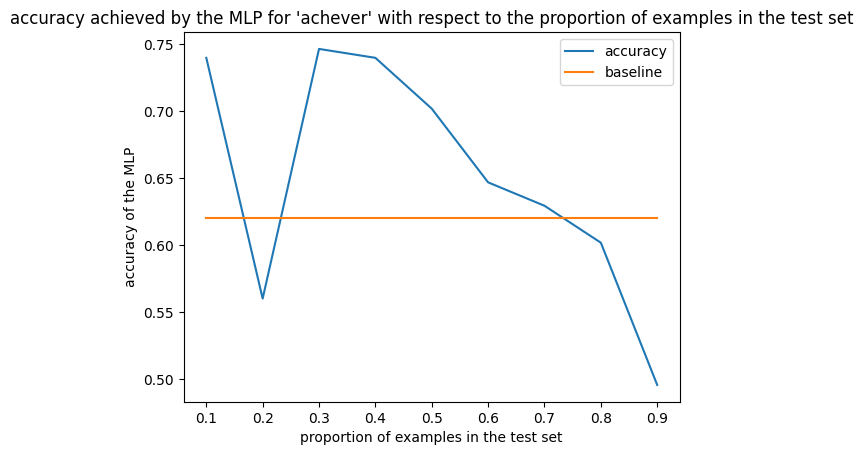

In [30]:
def plot_accuracy_MLP(lemma, nb_split):
  """
  plots the accuracy of the MLP for a given lemma depending on the proportion of examples in the test set.
  nb_splits: number of times the accuracy is computed with a different split.
  """
  accuracies = []
  for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
    examples = get_examples(lemma)
    X = [ex.vector for ex in examples]
    y = [ex.sense for ex in examples]
    mean_split = 0
    for split in range(nb_split):
      X_train, X_test, y_train, y_test = train_test_split_manual(X, y, proportion_test=proportion)
      clf = MLPClassifier(max_iter=300, hidden_layer_sizes=100).fit(X_train, y_train)
      mean_split += clf.score(X_test,y_test)
    mean_split = mean_split/ nb_split
    accuracies.append(mean_split)

  plt.plot(np.arange(0.1, 1, 0.1), accuracies, label='accuracy')
  plt.plot(np.arange(0.1, 1, 0.1), [get_baseline(examples) for _ in np.arange(0.1, 1, 0.1)], label='baseline')
  plt.xlabel("proportion of examples in the test set")
  plt.ylabel("accuracy of the MLP")
  plt.legend()
  plt.title(f"accuracy achieved by the MLP for '{examples[0].ambiguous_lemma}' with respect to the proportion of examples in the test set")

plot_accuracy_MLP("achever", 5)

We also tried the MLP on the word 'tank' of the TWA dataset.

In [31]:
# MLP with TWA dataset
X_tank = [ex.vector for ex in corpus.instances]
y_tank = [ex.sense for ex in corpus.instances]
clf = MLPClassifier()
mean = 0
for _ in range(5):
  X_train, X_test, y_train, y_test = train_test_split(X_tank, y_tank, test_size=0.2)
  clf.fit(X_train, y_train)
  mean += clf.score(X_test, y_test)

print("score MLP: ", mean / 5)
print("baseline: ", get_baseline(corpus.instances))

score MLP:  0.7853658536585366
baseline:  0.6268656716417911


### Tuning of Hyperparameters :

To tune the hyperparameters we used the `GridSearchCV` implemenation from sklearn (cf. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

It consists of an exhaustive search over specified parameter values for a given estimator.

In [32]:
from sklearn.model_selection import GridSearchCV


examples = get_examples('achever')
X = [ex.vector for ex in examples]
y = [ex.sense for ex in examples]
mean_splits=0
for split in range(5):
  X_train, X_test, y_train, y_test = train_test_split_manual(X, y, proportion_test=0.3)
  mlp = MLPClassifier(max_iter=300)
  parameter_space = {
  'hidden_layer_sizes': [50,100,200],
  'activation': ['tanh', 'relu','identity','logistic'],
  'solver': ['sgd', 'adam'],
  'learning_rate_init': [0.0001,0.001,0.01,0.1],
  }
  clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=2)
  clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels
  print(clf.best_params_)
  score=clf.score(X_test,y_test)
  print(f"split {split} score: {score}")
  mean_splits+= score
mean_splits=mean_splits/5
print(f"mean score over splits: {mean_splits}")


{'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.0001, 'solver': 'adam'}
split 0 score: 0.8
{'activation': 'tanh', 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01, 'solver': 'sgd'}
split 1 score: 0.7333333333333333
{'activation': 'tanh', 'hidden_layer_sizes': 50, 'learning_rate_init': 0.0001, 'solver': 'adam'}
split 2 score: 0.5333333333333333
{'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.001, 'solver': 'sgd'}
split 3 score: 0.5714285714285714
{'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.0001, 'solver': 'adam'}
split 4 score: 0.6666666666666666
mean score over splits: 0.6609523809523808


**Test of cosine similarity between embeddings:** 2 examples with similar sense are not necessarily closer...

In [33]:
print([y_achever[i] for i in range(4)])
print(np.dot(X_achever[0], X_achever[1]) / (norm(X_achever[0]) * norm(X_achever[1])))
print(np.dot(X_achever[3], X_achever[4]) / (norm(X_achever[3]) * norm(X_achever[4])))

['__ws_1_achever__verb__', '__ws_3_achever__verb__', '__ws_1_achever__verb__', '__ws_1_achever__verb__']
0.6888316
0.6540514


## **2) Basic K-means**

In the following code we define the class for the basic K-means clustering algortihm:


In [59]:
class Kmeans:
    def __init__(self, k, X, dist='cosine'):
        """
        :param k: number of clusters
        :param X: input data, shape [examples, features]
        :param dist: distance metric ('euclidian' or 'cosine')
        """
        self.k = k
        self.X = X
        self.dist = dist

    def fit(self):
        # Step 1: initialize randomly the k means
        centroids = []  # list of k centroids
        clusters = {}  # keys: the k clusters, values: the vectors belonging to each cluster
        for x in range(self.k):
            centroids.append(random.choice([ex.vector for ex in self.X]))  # choose k vectors randomly
            clusters[x] = []  # initializing the dictionary for each cluster from 0 to k
        previous_clusters = copy.deepcopy(clusters)
        while True:
            # Step 2: cluster assignment
            for example in self.X:
                distances_to_centroids = []
                for point in centroids:
                    distances_to_centroids.append(self.distance(example.vector, point))
                # print(distances_to_centroids)  # always very close from each other...
                # add the vector to its closest cluster:
                if self.dist == 'euclidian':  # max for cosine similarity, min for Euclidian distance
                    clusters[distances_to_centroids.index(min(distances_to_centroids))].append(example)
                elif self.dist == 'cosine':
                    clusters[distances_to_centroids.index(max(distances_to_centroids))].append(example)
            # Stopping condition: if same clusters twice in a row
            # test for each cluster if equal to previous cluster
            equal = [False if not np.array_equal([ex.vector for ex in clusters[x]], [ex.vector for ex in previous_clusters[x]]) else True for x in range(self.k)]
            if False not in equal:
                self.score(clusters)
                return clusters
            # Step 3: centroid update
            previous_clusters = copy.deepcopy(clusters)
            centroids = []
            for x in range(self.k):
                if clusters[x] != []:  # Problem: sometimes empty cluster
                    centroids.append(np.mean([ex.vector for ex in clusters[x]], axis=0))
                clusters[x] = []  # reinitialize at each iteration

    def distance(self, vector, centroid):
      """
      Args:
        - vector: np.array
        - centroid: np.array
      Returns:
        - either cosine or euclidiean distance between vector and centroid
      """
      if self.dist == 'euclidian':
          return math.dist(vector, centroid)  # Euclidian distance
      elif self.dist == 'cosine':
          cosine = np.dot(vector, centroid) / (norm(vector) * norm(centroid))
          return cosine

    def score(self, clusters):
      """
      Args:
        - clusters: dict()
      Returns:
        - scores: dict() with key= nb of cluster and value: [proportion of majority label in the claster, majority label]
      """
      scores = {}  # keys: the k clusters, values: list [proportion of majority label in this cluster, the majority label]
      for k in clusters:
          scores[k] = []
          if clusters[k] != []:
              senses_in_cluster = [ex.sense for ex in clusters[k] if ex.sense != 'undefined']
              most_frequent = max(set(senses_in_cluster), key= senses_in_cluster.count)
              count = len([ex.sense for ex in clusters[k] if (ex.sense == most_frequent) and  (ex.sense != 'undefined')])
              scores[k].append("{:.2f}".format(count / len(senses_in_cluster))) #len(clusters[k]
              scores[k].append(most_frequent)
          else:
              print(f"no label with this sense in cluster {k}")
      print(scores)
      return scores

    def score_accuracy(self, clusters, X_test):
      """
      Calculates the accuracy of the clustering by assigning each example in X_test to its closest cluster.
        Prediction is considered to be correct if the label of the example corresponds to the majority class of word senses in the cluster.
      Args:
        - clusters: dict()
        - X_test: list of Example instances
      Returns:
        -accuracy  of the clustering given a test set of Examples
      """
      centroids = [np.mean([ex.vector for ex in clusters[x]], axis=0) for x in range(self.k) if clusters[x] != []]
      clusters2sense = {}  # keys: the k clusters, values: the most frequent sense in each cluster
      for k in range(self.k):
          senses_in_cluster = [ex.sense for ex in clusters[k] if ex.sense != 'undefined']
          if senses_in_cluster != []:
              clusters2sense[k] = max(set(senses_in_cluster), key=senses_in_cluster.count)

      count = 0
      for ex in X_test:
          distances_to_centroids = []
          for point in centroids:
              distances_to_centroids.append(self.distance(ex.vector, point))
          if self.dist == 'euclidian':  # max for cosine similarity, min for Euclidian distance
              closest_cluster = distances_to_centroids.index(min(distances_to_centroids))
          elif self.dist == 'cosine':
              closest_cluster = distances_to_centroids.index(max(distances_to_centroids))
          # Prediction is correct if the sense represented by the closest cluster is the gold sense
          if clusters2sense[closest_cluster] == ex.sense:
              count += 1
      return count / len(X_test)

### **Train-Test-Split for Kmeans Clustering**

The following method for splitting a set of `Example` instances into a train and a test set has following objectif:



*   Both sets should contain all word senses in a balanced way (depending on `proportion_test`)
*   For unique word senses, they will be in the train set
*   Before splitting the list of `Example `instances will be shuffled
*   When adding unlabled data to the set of `Example` instances, they will be in the train set







In [60]:

def train_test_split_Examples(X, proportion_test=0.25, shuffle_data=True):
  """
  Splits the data into test and training data and ensures that both sets contain all word senses in a balanced way according to proportion_test.
  If a word sense exists only once, it will be in the training set.
  Unannotated examples with 'undefined' word sense are always added to X_train

  Args:
      X: list of Example instances
      proportion_test: float, optional (default=0.25)
          Proportion of the data to be included in the test set.
      shuffle_data: bool, optional (default=True)
          Whether to shuffle the data before splitting.

  Returns:
      X_train: list of Example instances
      X_test: list of Example instances

  """
  # Shuffle data if required
  if shuffle_data:
      random.shuffle(X)

  # get word senses of X
  senses = get_senses(X)

  # Find unique word senses and their counts
  unique_senses, sense_counts = np.unique([ex.sense for ex in X], return_counts=True)

  # Identify word senses occurring only once
  single_occurrence_senses = unique_senses[sense_counts == 1]

  #Create empty lists for test and train set
  X_train,X_test =list(),list()

  #iterate over possible word senses in X
  for sense_idx,u_s in enumerate(unique_senses): # u_s: unique sense in unique_senses
    i,X_idx=1,0 # X_idx: iterator over examples in X , i: iterator of number of examples of a word sense to put in X_train
    # while there are still examples in X and either the example is non annotated ('undefined') or the word sense is unique or proportion of word sense to add is not reached
    while (X_idx < len(X)) and ( u_s == "undefined" or sense_counts[sense_idx]==1 or (i<sense_counts[sense_idx]*(1-proportion_test))):
      # search for word with current word sense in X
      if X[X_idx ].sense == u_s:
        # add to train
        X_train.append(X[X_idx])

        X_idx +=1
        i+=1
      else:#if the current word has not the sense we are currently searching for
        X_idx +=1
    # adding the remaining examples of the sense to X_test
    X_test+=[v for v in X if (v.sense==u_s and v not in X_train) and u_s!="undefined" and sense_counts[sense_idx]!=1 ]

  return X_train, X_test



### **Testing the basic K-means on the FSE dataset:**


Plotting the accuracy of our K-means implementation over all ambiguous lemmas in the FSE corpus.



*   Increasing the proportion of the examples in the test set -> decreasing number of examples in the train set
*   Taking a mean accuracy over a given number of splits for each ambiguous lemma







mean baseline over all the examples:  0.635
{0: ['0.50', '__ws_1_relancer__verb__'], 1: ['0.83', '__ws_1_relancer__verb__'], 2: ['0.50', '__ws_1_relancer__verb__']}
{0: ['0.78', '__ws_1_relancer__verb__'], 1: ['0.56', '__ws_1_relancer__verb__'], 2: ['0.54', '__ws_1_relancer__verb__']}
{0: ['0.88', '__ws_1_relancer__verb__'], 1: ['0.52', '__ws_1_relancer__verb__'], 2: ['0.60', '__ws_1_relancer__verb__']}
{0: ['0.40', ' __ws_4_intervenir__verb__'], 1: ['0.50', '__ws_4_intervenir__verb__'], 2: ['1.00', ' __ws_1_intervenir__verb__'], 3: ['0.55', ' __ws_4_intervenir__verb__'], 4: ['0.50', '__ws_1_intervenir__verb__'], 5: ['0.50', ' __ws_4_intervenir__verb__']}
{0: ['0.38', '__ws_1_intervenir__verb__'], 1: ['1.00', ' __ws_4_intervenir__verb__'], 2: ['0.50', '__ws_4_intervenir__verb__'], 3: ['0.73', ' __ws_4_intervenir__verb__'], 4: ['0.25', '__ws_4_intervenir__verb__'], 5: ['0.47', ' __ws_1_intervenir__verb__']}
no label with this sense in cluster 5
{0: ['0.33', ' __ws_4_intervenir__verb__']

Text(0.5, 1.0, 'accuracy achieved by the Kmeans with respect to the proportion of examples in the test set')

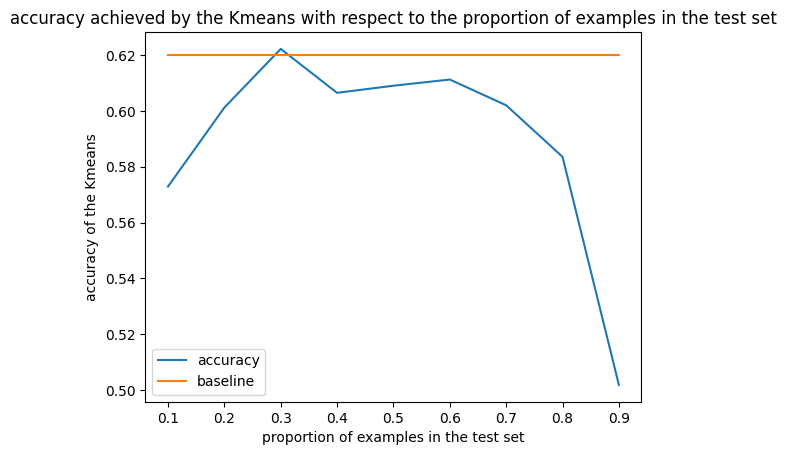

In [61]:
# with the FSE dataset



def get_accuracy_Kmeans(proportion_test_examples, nb_splits):
  """
  Args:
    - proportion_test_examples: float | proportion of examples in the test set
    - nb_splits: int | number of splits on for each set of examples
  Returns:
    - mean accuracy over all ambiguois lemmas
  """
  mean_accuracy_kmeans = 0
  mean_nb_train_examples = 0
  for lemma in ambiguous_lemmas_set:
      examples = get_examples(lemma)
      mean_split=0
      for split in range(nb_splits):
        X_train, X_test = train_test_split_Examples(examples, proportion_test=proportion_test_examples, shuffle_data=True)
        my_Kmeans = Kmeans(get_nb_senses(examples), X_train, dist='cosine')
        clusters = my_Kmeans.fit()
        mean_split+= my_Kmeans.score_accuracy(clusters, X_test)
      mean_nb_train_examples += len(X_train)
      mean_split= mean_split/nb_splits
      mean_accuracy_kmeans+=mean_split

  mean_accuracy_kmeans = mean_accuracy_kmeans / len(ambiguous_lemmas_set)
  print("mean number of training examples: ", mean_nb_train_examples / len(ambiguous_lemmas_set))
  print("mean accuracy of the Kmeans over all the examples: ", "{:.3f}".format(mean_accuracy_kmeans))
  return mean_accuracy_kmeans

print("mean baseline over all the examples: ", "{:.3f}".format(mean_baseline))

# Plot the accuracies of the basic Kmeans:
accuracies = []
# proportion of the test size: smaller proportion = more examples to train the Kmeans.
for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_Kmeans(proportion, nb_splits=3))

plt.plot(np.arange(0.1, 1, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 1, 0.1), [get_baseline(examples) for _ in np.arange(0.1, 1, 0.1)], label='baseline')
plt.legend()
plt.xlabel("proportion of examples in the test set")
plt.ylabel("accuracy of the Kmeans")
plt.title("accuracy achieved by the Kmeans with respect to the proportion of examples in the test set")

Testing the basic K-means implementation on the ambiguous word 'tank' from the TWA corpus:


In [37]:
# with the TWA dataset
X_train_TWA, X_test_TWA = train_test_split(corpus.instances, test_size=0.8)
my_kmeans_tank = Kmeans(get_nb_senses(corpus.instances), X_train_TWA, dist='cosine')
clusters_TWA = my_kmeans_tank.fit()
accuracy_tank = my_kmeans_tank.score_accuracy(clusters_TWA, X_test_TWA)
print(len(X_train_TWA))
print("accuracy: ", "{:.3f}".format(accuracy_tank))
print("baseline: ", "{:.3f}".format(get_baseline(corpus.instances)))

{0: ['0.50', 'tank%vehicle'], 1: ['0.69', 'tank%container']}
40
accuracy:  0.578
baseline:  0.627


Test with simple examples

In [38]:
examples_test = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0], [100, 0], [100, 2], [100, 4]]) # to test: remove '.vector' in Kmeans
# my_kmeans_test = Kmeans(3, examples_test, dist='euclidian')
# my_kmeans_test.fit()

## **3) Constrained K-means**

The following class implements the constrained K-means algorithm. It enherits from the basic `Kmeans` class and has an additional method `get_seed` in order to define the initial seeds for the initial centroids of the clustering.

In [39]:

class constrained_Kmeans(Kmeans):
    def __init__(self, k, X, seed, dist='euclidian'):
        """
        :param seed: list of Example instances used to initialize the k clusters. At least one example for each sense
        """
        Kmeans.__init__(self, k, X, dist)
        self.seed = seed
    def fit(self):
        # Step 1: initialize the k means with the seed examples
        centroids = []  # choose k vectors randomly
        clusters = {}  # keys: the k clusters, values: the vectors belonging to each cluster
        senses = []
        for ex in self.seed:
            if (ex.sense not in senses) and (ex.sense != 'undefined'):
              senses.append(ex.sense)
        if len(senses) != self.k:
            print("seeded examples do not contain all possible senses")
        for x in range(self.k):
            # initializing the dictionary for each cluster from 0 to k with the seed examples:
            clusters[x] = [ex for ex in self.seed if (ex.sense == senses[x]) and (ex.sense != 'undefined')]
            # initializing the centroids with the mean of each cluster:
            centroids.append(np.mean([ex.vector for ex in clusters[x]], axis=0))
        previous_clusters = copy.deepcopy(clusters)
        while True:
            # Step 2: cluster assignment
            for example in self.X:
                distances_to_centroids = []
                for point in centroids:
                    distances_to_centroids.append(self.distance(example.vector, point))
                # print(distances_to_centroids)
                # add the vector to its closest cluster:
                if self.dist == 'euclidian':  # max for cosine similarity, min for Euclidian distance
                    clusters[distances_to_centroids.index(min(distances_to_centroids))].append(example)
                elif self.dist == 'cosine':
                    clusters[distances_to_centroids.index(max(distances_to_centroids))].append(example)
            # Stopping condition: if same clusters twice in a row
            equal = [False if not np.array_equal([ex.vector for ex in clusters[x]], [ex.vector for ex in previous_clusters[x]]) else True for x in range(self.k)]
            if False not in equal:
                self.score(clusters)
                return clusters
            # Step 3: centroid update
            previous_clusters = copy.deepcopy(clusters)
            centroids = []
            for x in range(self.k):
                centroids.append(np.mean([ex.vector for ex in clusters[x]], axis=0))
                clusters[x] = [ex for ex in self.seed if (ex.sense == senses[x]) and (ex.sense != 'undefined') ]  # reinitialize at each iteration  ?with [] or seeded examples ?

def get_seed(corpus, proportion):
    """
    :param corpus: list of Example instances
    :param proportion: proportion of the examples we want to input as seed to the constrained K-means. Between 0 - 1
    :return: - list of Example instances for the seed, with at least 1 example per possible sense
             - rest of the examples
    """
    examples = corpus.copy()
    seed = []
    #size = int(proportion * len(examples))  # size of the seed
    senses = get_senses(examples)
    examples_k = []  # list with, at position k, the list of examples with sense senses[k]
    for k in range(len(senses)):  # to get an equilibrate seed, we add an example from each sense at each iteration
        examples_k.append([ex for ex in examples if( ex.sense == senses[k]) and (ex.sense!= 'undefined') ])
    for exs in  examples_k:
        size = int(proportion * len(exs))
        if size == 0:
            size = 1 # seed must contain at least 1 example for each sense
        sampled_exs = random.sample(exs, size)
        for ex in sampled_exs:
            seed.append(ex)
            examples.remove(ex)
    return seed, examples



### Testing the constrained K-means on the FSE dataset:


Plotting the accuracy of our constrained K-means implementation over all ambiguous lemmas in the FSE corpus.



*   Increasing the proportion of the examples in the test set -> decreasing number of examples in the train set






with constrained K-means:
mean baseline over all the examples:  0.635
{0: ['0.91', '__ws_1_relancer__verb__'], 1: ['0.63', '__ws_6_relancer__verb__'], 2: ['1.00', '__ws_2_relancer__verb__']}
{0: ['0.75', '__ws_1_intervenir__verb__'], 1: ['0.50', ' __ws_4_intervenir__verb__'], 2: ['1.00', '__ws_3_intervenir__verb__'], 3: ['0.67', ' __ws_4_intervenir__verb__'], 4: ['0.45', ' __ws_1_intervenir__verb__'], 5: ['1.00', ' __ws_3_intervenir__verb__']}
{0: ['0.87', '__ws_1_préférer__verb__'], 1: ['0.73', '__ws_3_préférer__verb__'], 2: ['0.50', '__ws_1_préférer__verb__']}
{0: ['0.95', ' __ws_2_confier__verb__'], 1: ['0.80', ' __ws_1_confier__verb__']}
{0: ['0.92', '__ws_2_respecter__verb__'], 1: ['0.58', '__ws_2_respecter__verb__']}
{0: ['0.85', '__ws_6_dominer__verb__'], 1: ['0.92', '__ws_6_dominer__verb__'], 2: ['0.67', '__ws_6_dominer__verb__'], 3: ['0.57', '__ws_4_dominer__verb__']}
{0: ['0.46', ' __ws_1a_conclure__verb__'], 1: ['1.00', ' __ws_1b_conclure__verb__'], 2: ['0.63', ' __ws_1a_con

Text(0.5, 1.0, 'accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set')

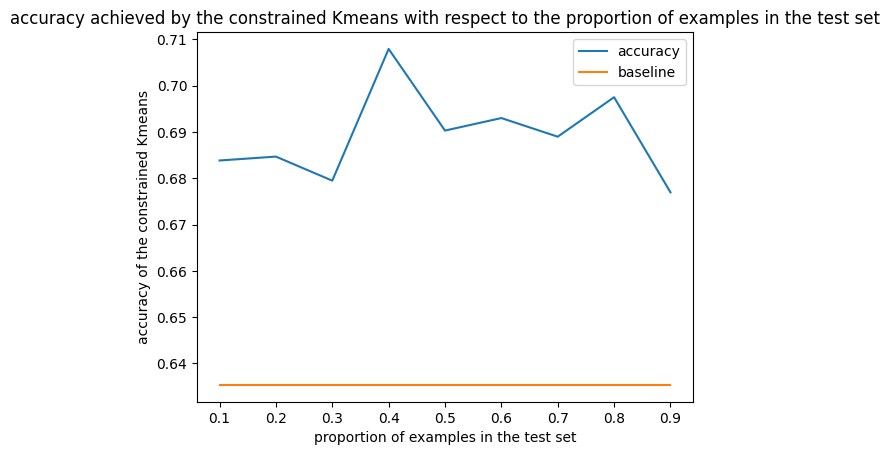

In [40]:
print("with constrained K-means:")

def get_accuracy_constr_kmeans(proportion_test_examples, proportion_seed):
  """
  Args:
    - proportion_test_examples: float | proportion of examples in the test set
    - proportion_seed: float | proportion of examples in the seed
  Returns:
    - mean accuracy over all ambiguous lemmas
  """

  mean_accuracy_constr_kmeans = 0
  for lemma in ambiguous_lemmas_set:
      examples = get_examples(lemma)
      X_train, X_test = train_test_split(examples, test_size=proportion_test_examples)
      seed, X_train = get_seed(examples, proportion_seed)
      my_constr_Kmeans = constrained_Kmeans(get_nb_senses(examples), X_train, seed, dist='cosine')
      clusters = my_constr_Kmeans.fit()
      mean_accuracy_constr_kmeans += my_constr_Kmeans.score_accuracy(clusters, X_test)
      #print(my_Kmeans.score_accuracy(clusters, X_test))

  mean_accuracy_constr_kmeans = mean_accuracy_constr_kmeans / len(ambiguous_lemmas_set)
  print("mean accuracy of the constrained Kmeans over all the examples: ", "{:.3f}".format(mean_accuracy_constr_kmeans))
  return mean_accuracy_constr_kmeans

print("mean baseline over all the examples: ", "{:.3f}".format(mean_baseline))

# Plot the accuracies of the constrained Kmeans:
accuracies = []
# proportion of the test size: smaller proportion = more examples to train the Kmeans.
for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_constr_kmeans(proportion, 0.4))

plt.plot(np.arange(0.1, 1, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 1, 0.1), [mean_baseline for _ in np.arange(0.1, 1, 0.1)], label='baseline')
plt.legend()
plt.xlabel("proportion of examples in the test set")
plt.ylabel("accuracy of the constrained Kmeans")
plt.title("accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set")


### **Plotting accuracy of constrained Kmeans depending on the proportion of examples in the seed**

{0: ['0.59', '__ws_1_relancer__verb__'], 1: ['0.75', '__ws_6_relancer__verb__'], 2: ['0.75', '__ws_1_relancer__verb__']}
{0: ['0.60', '__ws_1_intervenir__verb__'], 1: ['1.00', '__ws_4_intervenir__verb__'], 2: ['1.00', '__ws_3_intervenir__verb__'], 3: ['0.46', ' __ws_4_intervenir__verb__'], 4: ['1.00', ' __ws_1_intervenir__verb__'], 5: ['0.50', ' __ws_4_intervenir__verb__']}
{0: ['0.74', '__ws_1_préférer__verb__'], 1: ['0.71', '__ws_1_préférer__verb__'], 2: ['0.50', '__ws_1_préférer__verb__']}
{0: ['0.88', ' __ws_2_confier__verb__'], 1: ['0.88', ' __ws_1_confier__verb__']}
{0: ['0.86', '__ws_2_respecter__verb__'], 1: ['0.60', '__ws_2_respecter__verb__']}
{0: ['0.91', '__ws_6_dominer__verb__'], 1: ['0.75', '__ws_6_dominer__verb__'], 2: ['0.82', '__ws_6_dominer__verb__'], 3: ['0.46', '__ws_6_dominer__verb__']}
{0: ['0.62', ' __ws_1a_conclure__verb__'], 1: ['0.64', ' __ws_1b_conclure__verb__'], 2: ['0.62', ' __ws_1b_conclure__verb__'], 3: ['0.67', ' __ws_1a_conclure__verb__'], 4: ['0.50', 

Text(0.5, 1.0, 'accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the seed')

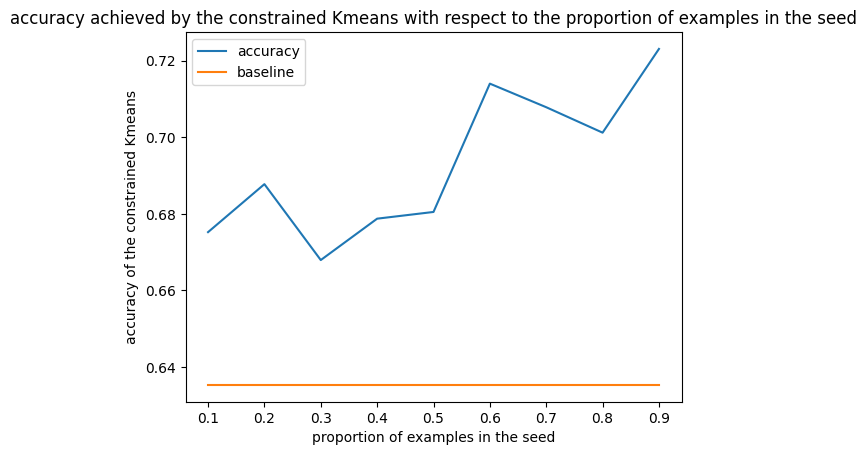

In [41]:
# Plot the accuracies of the constrained Kmeans depending on the proportion of examples in the seed:
accuracies = []
# proportion of the seed: smaller proportion = less examples to initialize the Kmeans.
for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_constr_kmeans(0.25, proportion))

plt.plot(np.arange(0.1, 1, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 1, 0.1), [mean_baseline for _ in np.arange(0.1, 1, 0.1)], label='baseline')
plt.legend()
plt.xlabel("proportion of examples in the seed")
plt.ylabel("accuracy of the constrained Kmeans")
plt.title("accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the seed")

Testing the constrained K-means on 'tank' from  TWA corpus:

In [42]:
# constrained K-means with TWA dataset
X_train, X_test = train_test_split(corpus.instances, test_size=0.8)
seed, X = get_seed(X_train, 0.4)
print(len(X_train))
my_constr_kmeans_tank = constrained_Kmeans(get_nb_senses(corpus.instances), X, seed, dist='cosine')
clusters = my_constr_kmeans_tank.fit()
print(my_constr_kmeans_tank.score_accuracy(clusters, X_test))

40
{0: ['0.77', 'tank%container'], 1: ['0.80', 'tank%vehicle']}
0.6521739130434783


## **Plotting a comparison of accuracies for the different models and a given lemma :**



*   MLP
*   Basic K-means
*   Constrained K-means










{0: ['0.82', ' __ws_2_confier__verb__'], 1: ['0.82', ' __ws_1_confier__verb__']}
{0: ['1.00', ' __ws_1_confier__verb__'], 1: ['1.00', ' __ws_2_confier__verb__']}
{0: ['0.65', ' __ws_2_confier__verb__'], 1: ['0.85', ' __ws_1_confier__verb__']}
{0: ['1.00', ' __ws_1_confier__verb__'], 1: ['0.96', ' __ws_2_confier__verb__']}
{0: ['1.00', ' __ws_2_confier__verb__'], 1: ['0.73', ' __ws_1_confier__verb__']}
{0: ['1.00', ' __ws_1_confier__verb__'], 1: ['1.00', ' __ws_2_confier__verb__']}
{0: ['1.00', ' __ws_2_confier__verb__'], 1: ['0.73', ' __ws_1_confier__verb__']}
{0: ['0.96', ' __ws_1_confier__verb__'], 1: ['1.00', ' __ws_2_confier__verb__']}
{0: ['0.90', ' __ws_1_confier__verb__'], 1: ['0.87', ' __ws_2_confier__verb__']}
{0: ['1.00', ' __ws_1_confier__verb__'], 1: ['0.92', ' __ws_2_confier__verb__']}
{0: ['0.83', ' __ws_2_confier__verb__'], 1: ['0.80', ' __ws_1_confier__verb__']}
{0: ['1.00', ' __ws_1_confier__verb__'], 1: ['1.00', ' __ws_2_confier__verb__']}
{0: ['0.83', ' __ws_1_confie

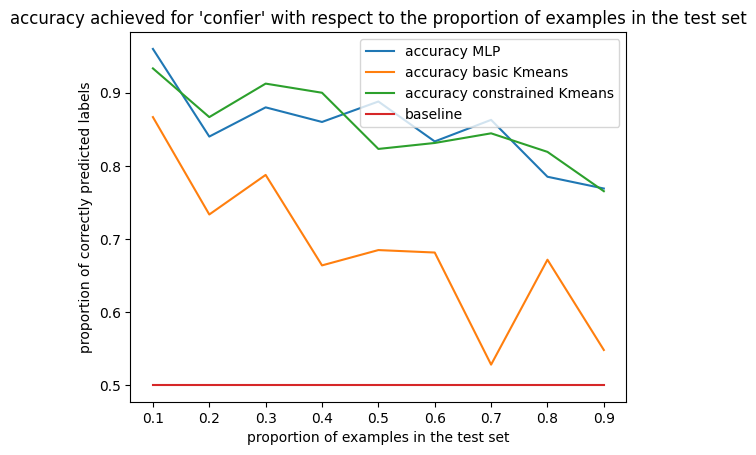

In [43]:
def plot_accuracy_comparison(lemma, nb_split):
  """
  plots the accuracy of the MLP, the basic Kmeans and the constrained Kmeans
   for a given lemma depending on the proportion of examples in the test set.

  Args:
    -lemma: String | lemma to plot the accuracies for
    -nb_splits: int| number of times the accuracy is computed with a different split.
  """
  accuracies_MLP = []
  accuracies_Kmeans = []
  accuracies_constr_Kmeans = []
  for proportion in np.arange(0.1, 1, 0.1):  # 0.1, 0.2... to 0.9
    examples = get_examples(lemma)
    X = [ex.vector for ex in examples]
    y = [ex.sense for ex in examples]
    mean_split_MLP = 0
    mean_split_Kmeans = 0
    mean_split_constr_Kmeans = 0
    for split in range(nb_split):
      X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split_manual(X, y, proportion_test=proportion)  # for MLP
      X_train, X_test = train_test_split_Examples(examples, proportion_test=proportion, shuffle_data=True)  # for Kmeans

      clf = MLPClassifier(max_iter=300, hidden_layer_sizes=100).fit(X_train_MLP, y_train_MLP)
      mean_split_MLP += clf.score(X_test_MLP, y_test_MLP)

      my_Kmeans = Kmeans(get_nb_senses(examples), X_train, dist='cosine')
      clusters = my_Kmeans.fit()
      mean_split_Kmeans += my_Kmeans.score_accuracy(clusters, X_test)

      seed, X_train_constr = get_seed(X_train, 0.9)
      my_constr_Kmeans = constrained_Kmeans(get_nb_senses(examples), X_train_constr, seed, dist='cosine')
      clusters_constr = my_constr_Kmeans.fit()
      mean_split_constr_Kmeans += my_constr_Kmeans.score_accuracy(clusters_constr, X_test)

    accuracies_MLP.append(mean_split_MLP / nb_split)
    accuracies_Kmeans.append(mean_split_Kmeans / nb_split)
    accuracies_constr_Kmeans.append(mean_split_constr_Kmeans / nb_split)

  proportions = np.arange(0.1, 1, 0.1)
  plt.plot(proportions, accuracies_MLP, label='accuracy MLP')
  plt.plot(proportions, accuracies_Kmeans, label='accuracy basic Kmeans')
  plt.plot(proportions, accuracies_constr_Kmeans, label='accuracy constrained Kmeans')
  plt.plot(proportions, [get_baseline(examples) for _ in proportions], label='baseline')
  plt.xlabel("proportion of examples in the test set")
  plt.ylabel("proportion of correctly predicted labels")
  plt.legend()
  plt.title(f"accuracy achieved for '{examples[0].ambiguous_lemma}' with respect to the proportion of examples in the test set")

plot_accuracy_comparison("confier", 5)

# **Plot the embeddings for a given lemma**

Dimension reduction of the embeddings with PCA to 3 dimensions.

https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d


For the FSE corpus:

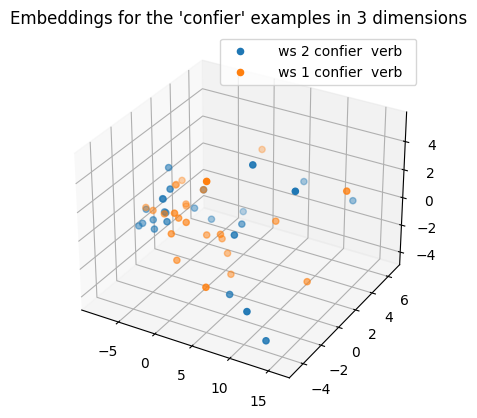

In [44]:
def plot_embeddings(ambiguous_lemma):
  """
  Args:
    -ambiguous_lemma: string
  """
  pca = PCA(n_components=3)
  examples = get_examples(ambiguous_lemma)
  senses = get_senses(examples)
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  for sense in senses:
      ex_sense = [ex.vector for ex in examples if ex.sense == sense]
      if len(ex_sense) > 3: # if less than 3 examples, dimension reduction to 3 dimensions is impossible
          vector = pca.fit_transform(ex_sense)
          ax.scatter(vector[:, 0], vector[:, 1], vector[:, 2], label=sense.replace('_', ' '))
  ax.legend()
  plt.title(f"Embeddings for the '{ambiguous_lemma}' examples in 3 dimensions")
  plt.show()

plot_embeddings('confier')


#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='yellow')


For the TWA dataset:

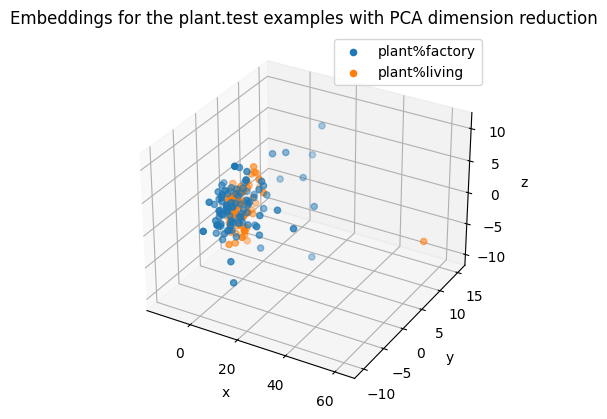

In [45]:
def plot_embeddings_TWA(corpus_path):
    """
    :param corpus_path: path to a corpus from the TWA dataset
    :return: plot in 3d of the vectors of the given Examples
    """
    corpus = Examples_collection(corpus_path, embeddings_TWA)
    pca3 = PCA(n_components=3)
    senses = get_senses(corpus.instances)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for sense in senses:
        vectors = [ex.vector for ex in corpus.instances if ex.sense == sense]
        vectors3d = pca3.fit_transform(vectors)
        ax.scatter(vectors3d[:, 0], vectors3d[:, 1], vectors3d[:, 2], label=sense)
    ax.legend()
    plt.title(f"Embeddings for the {corpus_path} examples with PCA dimension reduction")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

plot_embeddings_TWA("plant.test")

# **4) Adding unlabeled data to the constrained K-means clustering**

In this section we will add unlabaled data from the  "Est Républicain" corpus to the labeled data from the FSE datset in order to evaluate if adding unlabaled data can enhance the accuracy of the algorithm

In order to do so we will:


*   extract the data from the CoNNL-U files of the corpus
*   create `Example` instances from the unlabaled data having word sense 'undefined'
*   add examples from 1 file to the FSE labeled data and evaluate the accuracy
*   add examples from 5 files to the FSE labeled data and evaluate the accuracy



## Read CONLLU files

In [46]:
STOP_WORDS_FR= [".", "!", "?", ":", ";", "alors", "au", "aucun", "aussi", "autre", "avant", "avec", "avoir", "bon", "car", "ce", "cela", "ces", "ceux", "chaque", "ci", "comme", "comment", "dans", "des", "du", "dedans", "dehors", "depuis", "devrait", "doit", "donc", "elle", "elles", "en", "encore", "est", "et", "eu", "fait", "faites", "fois", "font", "hors", "ici", "il", "ils", "je", "juste", "la", "le", "les", "leur", "là", "ma", "maintenant", "mais", "mes", "mien", "moins", "mon", "mot", "même", "ni", "nommés", "notre", "nous", "ou", "où", "par", "parce", "pas", "peut", "peu", "plupart", "pour", "pourquoi", "quand", "que", "quel", "quelle", "quelles", "quels", "qui", "sa", "sans", "ses", "seulement", "si", "sien", "son", "sont", "sous", "soyez", "sur", "ta", "tandis", "tellement", "tels", "tes", "ton", "tous", "tout", "trop", "très", "tu", "voient", "vont", "votre", "vous", "vu", "ça", "étaient", "état", "étions", "été", "être"]
def tokenize(filename):
    """
    Args:
      -filename: String (path to conllu file)
    Returns:
      - list of sentences (list of lists)
    """
    list_sentences = []

    with open(filename, "r", encoding="utf8") as corpus:
        sentence = []
        for line in corpus:
            if line.startswith('#'):
                continue

            if line.strip() == '':
                if sentence:
                    list_sentences.append(sentence)
                    sentence = []
                continue

            parts = line.strip().split('\t')
            word = parts[2].replace(" ", "")
            if word not in STOP_WORDS_FR:
              sentence.append(word)


        # Check if there is a remaining sentence at the end
        if sentence:
            list_sentences.append(sentence)

    return list_sentences




From all the sentences extracted from the CoNNL-U file we want to only keep those containing one of the ambiguous lemmas also present in the FSE dataset.

In [47]:
ambiguous_lemmas_FSE=list()

for lemma in ambiguous_lemmas:
  if lemma not in ambiguous_lemmas_FSE:
    ambiguous_lemmas_FSE.append(lemma)

print(ambiguous_lemmas_FSE)

def get_examples_conllu(list_sentences, list_ambiguous_lemmas):
  """
      list_sentences: list[list[str]]
      list_ambiguous_lemmas: list[str] all possible ambiguous lemmas seen in FSE
      return: - list[list[str],str] list of sentences containing one  of the ambiguous lemmas and the ambiguous lemma
  """
  example_sentences=list()
  for sentence in list_sentences:
    for lemma in list_ambiguous_lemmas:
      if lemma in sentence:

        example_sentences.append([sentence,lemma])
  return example_sentences


['aboutir', 'investir', 'traduire', 'témoigner', 'juger', 'justifier', 'viser', 'prononcer', 'accomplir', 'convenir', 'acquérir', 'achever', 'observer', 'adapter', 'admettre', 'entraîner', 'payer', 'respecter', 'affecter', 'demeurer', 'aggraver', 'agir', 'ajouter', 'alimenter', 'coûter', 'relancer', 'préférer', 'appliquer', 'apporter', 'fonder', 'appuyer', 'changer', 'chuter', 'soutenir', 'concevoir', 'interroger', 'confirmer', 'transformer', 'manifester', 'interpeller', 'signer', 'rester', 'tuer', 'indiquer', 'conduire', 'situer', 'aider', 'poursuivre', 'profiter', 'détenir', 'lire', 'contenir', 'dominer', 'noter', 'dater', 'adopter', 'enregistrer', 'intervenir', 'conclure', 'disputer', 'estimer', 'appartenir', 'arriver', 'chercher', 'composer', 'confier']


In [48]:
#5 of the 78 conllu files to test

!gdown --id 1i3_XU3rZPygr0ajDFv4o2OkcanwrECvD
#/content/EP.tcs.melt.utf8.split-aa.outmalt

!gdown --id 1BNY3bJLYXP8K_s1TxhPYhLWedNNb0UcY
#/content/EP.tcs.melt.utf8.split-ab.outmalt

!gdown --id 1Kk3CS22UwoR-B0rtOCL5x3Jaw1_f1W7m
#/content/EP.tcs.melt.utf8.split-ac.outmalt

!gdown --id 1lpFBw4HOENPp2x-vZBH5ZmXKiIUULlKO
#/content/EP.tcs.melt.utf8.split-ad.outmalt

!gdown --id 1gmU_3jp1FHGi9seQEbUcIIRgMM7EQ306
#/content/EP.tcs.melt.utf8.split-ae.outmalt



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1i3_XU3rZPygr0ajDFv4o2OkcanwrECvD
To: /content/EP.tcs.melt.utf8.split-aa.outmalt
100% 72.9M/72.9M [00:01<00:00, 42.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BNY3bJLYXP8K_s1TxhPYhLWedNNb0UcY
To: /content/EP.tcs.melt.utf8.split-ab.outmalt
100% 68.8M/68.8M [00:01<00:00, 67.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Down

Tokenizing the CoNNL-U files:

In [49]:

sentences_conllu_aa=tokenize('/content/EP.tcs.melt.utf8.split-aa.outmalt')
sentences_conllu_ab=tokenize('/content/EP.tcs.melt.utf8.split-ab.outmalt')
sentences_conllu_ac=tokenize('/content/EP.tcs.melt.utf8.split-ac.outmalt')
sentences_conllu_ad=tokenize('/content/EP.tcs.melt.utf8.split-ad.outmalt')
sentences_conllu_ae=tokenize('/content/EP.tcs.melt.utf8.split-ae.outmalt')



Creating examples for **one** of the files:

In [50]:
examples_aa=get_examples_conllu(sentences_conllu_aa,ambiguous_lemmas_FSE)


Creating `Example` instances from the examples and add them to a list `examples_NA_one`.

Then implementing a method that extracts all `Example `instances for a given lemma from the `examples_NA_one` list.

In [51]:
examples_NA_one = list()

for sentence, lemma in examples_aa:
  examples_NA_one.append(Example(sentence, lemma, 'undefined'))  #embeddings_FSE

def get_example_lemma(ambiguous_lemma,examples_list):
  """
  Args:
    - ambiguous_lemma: String | lemma for which examples should be extracted
    - examples_list: list of Example instances
  Returns:
    - list of Example instances for a given ambiguous_lemma
  """
  examples_lemma=[]
  for ex in examples_list:
    if ex.ambiguous_lemma==ambiguous_lemma:
      examples_lemma.append(ex)
  return examples_lemma



Method to get the mean accuracy of the constrained Kmeans clustering over the FSE data and the additional non annotated data:

In [52]:
def get_accuracy_constr_kmeans_NA(proportion_test_examples, examples_non_annotated, nb_splits):
  """
  Calculates the mean accuracy for the constrained Kmeans by adding unlabaled data to the FSE data

  Args:
    - proportion_test_examples: float | proportion of data used in the test set
    - examples_non_annotated: list of Example instances
  Return:
    - mean accuracy over all ambiguous lemmas
  """
  mean_accuracy_constr_kmeans = 0
  for lemma in ambiguous_lemmas_set:
      examples = get_examples(lemma)
      examples_NA=get_example_lemma(lemma, examples_non_annotated)
      examples_total=examples + examples_NA
      random.shuffle(examples_total)
      mean_split=0
      for split in range(nb_splits):
        X_train, X_test = train_test_split_Examples(examples_total, proportion_test=proportion_test_examples, shuffle_data=True)
        seed, X_train_constr = get_seed(X_train, 0.4)
        my_constr_Kmeans = constrained_Kmeans(get_nb_senses(X_train), X_train_constr, seed, dist= "cosine")
        clusters = my_constr_Kmeans.fit()
        mean_split+= my_constr_Kmeans.score_accuracy(clusters, X_test)
      mean_split= mean_split/nb_splits
      mean_accuracy_constr_kmeans+=mean_split


  mean_accuracy_constr_kmeans = mean_accuracy_constr_kmeans / len(ambiguous_lemmas_set)
  print("mean accuracy of the constrained Kmeans over all the examples: ", "{:.3f}".format(mean_accuracy_constr_kmeans))
  return mean_accuracy_constr_kmeans

Method to get the accuracy for a given lemma adding the unlabeled examples to the examples present in the FSE corpus:


In [53]:
def get_accuracy_NA_lemma(lemma, examples, nb_files):
  """
  calculates the accuracy of the constrained Kmeans given an ambiguous lemma and a list of unlabled data

  Args:
    -lemma: String
    - examples: list of Example instances | list of unlabeled examples
    - nb_files: int | the number of files with unlabaled data used
  """
  print(f"number of unlabled examples for '{lemma}' in {nb_files} file: {len(get_example_lemma(lemma, examples))}")
  examples=get_examples(lemma)+get_example_lemma(lemma,examples) #create a list of annotated and non annotated examples
  X_train, X_test= train_test_split_Examples(examples,proportion_test=0.3)
  seed,X_train=get_seed(examples, 0.4)
  my_constr_Kmeans = constrained_Kmeans(get_nb_senses(examples),X_train,seed,dist='cosine')
  clusters=my_constr_Kmeans.fit()
  print(f"accuracy for {lemma} with {nb_files} additional files of unlabeled data: {my_constr_Kmeans.score_accuracy(clusters, X_test)}\n")



Plotting the mean accuracy over all ambiguous lemmas when adding **one** file of the "Est Républicain" corpus to the labeled data:

mean baseline over all the examples with one additional file of unlabeled data:  0.635
{0: ['0.94', '__ws_1_relancer__verb__'], 1: ['0.40', '__ws_1_relancer__verb__'], 2: ['0.64', '__ws_6_relancer__verb__']}
{0: ['0.86', '__ws_1_relancer__verb__'], 1: ['0.50', '__ws_6_relancer__verb__'], 2: ['0.65', '__ws_6_relancer__verb__']}
{0: ['0.89', '__ws_1_relancer__verb__'], 1: ['0.50', '__ws_6_relancer__verb__'], 2: ['0.62', '__ws_6_relancer__verb__']}
{0: ['1.00', ' __ws_1_intervenir__verb__'], 1: ['0.40', '__ws_1_intervenir__verb__'], 2: ['0.59', ' __ws_4_intervenir__verb__'], 3: ['0.67', ' __ws_4_intervenir__verb__'], 4: ['1.00', '__ws_3_intervenir__verb__'], 5: ['0.50', '__ws_4_intervenir__verb__']}
{0: ['0.55', ' __ws_1_intervenir__verb__'], 1: ['0.33', '__ws_1_intervenir__verb__'], 2: ['0.68', ' __ws_4_intervenir__verb__'], 3: ['1.00', '__ws_1_intervenir__verb__'], 4: ['1.00', '__ws_3_intervenir__verb__'], 5: ['1.00', '__ws_4_intervenir__verb__']}
{0: ['0.57', ' __ws_1_intervenir__verb_

Text(0.5, 1.0, 'accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set')

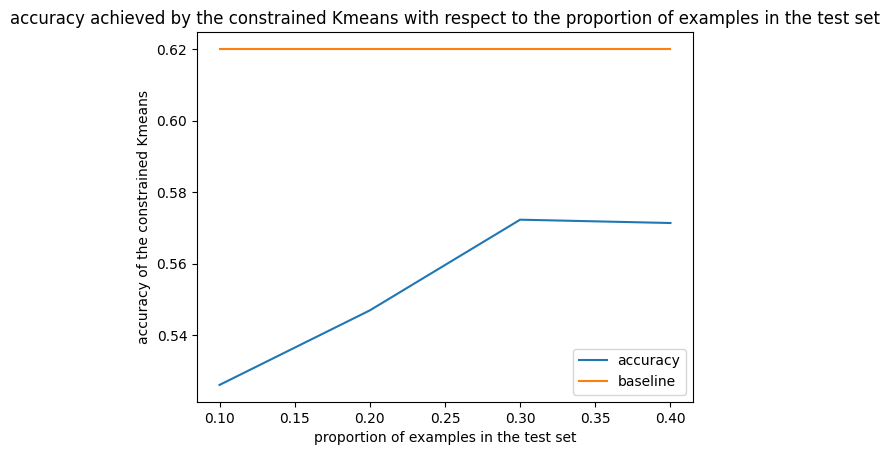

In [54]:


print("mean baseline over all the examples with one additional file of unlabeled data: ", "{:.3f}".format(mean_baseline))

# Plot the accuracies of the constrained Kmeans:
accuracies = []
# proportion of the test size: smaller proportion = more examples to train the Kmeans.
for proportion in np.arange(0.1, 0.5, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_constr_kmeans_NA(proportion, examples_NA_one,nb_splits=3))

plt.plot(np.arange(0.1, 0.5, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 0.5, 0.1), [get_baseline(examples) for _ in np.arange(0.1, 0.5, 0.1)], label='baseline')
plt.legend()
plt.xlabel("proportion of examples in the test set")
plt.ylabel("accuracy of the constrained Kmeans")
plt.title("accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set")

Comparing the accuracies for different ambiguous lemmas when adding **one** file to the labeled data:

In [55]:
get_accuracy_NA_lemma('estimer',examples_NA_one,1)
get_accuracy_NA_lemma('aggraver',examples_NA_one,1)
get_accuracy_NA_lemma('relancer',examples_NA_one,1)
get_accuracy_NA_lemma('confier',examples_NA_one,1)
get_accuracy_NA_lemma('disputer',examples_NA_one,1)

number of unlabled examples for 'estimer' in 1 file: 184
{0: ['1.00', '__ws_1_estimer__verb__'], 1: ['0.87', '__ws_3_estimer__verb__'], 2: ['0.83', '__ws_3_estimer__verb__']}
accuracy for estimer with 1 additional files of unlabeled data: 0.875

number of unlabled examples for 'aggraver' in 1 file: 16
{0: ['0.95', '__ws_1_aggraver__verb__'], 1: ['0.64', '__ws_2_aggraver__verb__']}
accuracy for aggraver with 1 additional files of unlabeled data: 0.8125

number of unlabled examples for 'relancer' in 1 file: 34
{0: ['0.50', '__ws_1_relancer__verb__'], 1: ['0.70', '__ws_1_relancer__verb__'], 2: ['0.50', '__ws_6_relancer__verb__']}
accuracy for relancer with 1 additional files of unlabeled data: 0.75

number of unlabled examples for 'confier' in 1 file: 160
{0: ['0.89', ' __ws_1_confier__verb__'], 1: ['1.00', ' __ws_2_confier__verb__']}
accuracy for confier with 1 additional files of unlabeled data: 0.875

number of unlabled examples for 'disputer' in 1 file: 224
{0: ['1.00', '__ws_5_disput

Creating examples from **five** files from the "Est Républicain" corpus:

In [56]:
examples_five=get_examples_conllu(sentences_conllu_aa,ambiguous_lemmas_FSE)+get_examples_conllu(sentences_conllu_ab,ambiguous_lemmas_FSE)+get_examples_conllu(sentences_conllu_ac,ambiguous_lemmas_FSE)+get_examples_conllu(sentences_conllu_ad,ambiguous_lemmas_FSE)+get_examples_conllu(sentences_conllu_ae,ambiguous_lemmas_FSE)

examples_NA_five = list()

for sentence, lemma in examples_five:
  examples_NA_five.append(Example(sentence, lemma, 'undefined'))  #embeddings_FSE

Plotting the mean accuracy over all ambiguous lemmas when adding **five** files of the "Est Républicain" corpus to the labeled data:

mean baseline over all the examples with five additional files of unlabeled data:  0.635
{0: ['0.84', '__ws_1_relancer__verb__'], 1: ['0.50', '__ws_6_relancer__verb__'], 2: ['0.58', '__ws_6_relancer__verb__']}
{0: ['0.84', '__ws_1_relancer__verb__'], 1: ['0.50', '__ws_6_relancer__verb__'], 2: ['0.59', '__ws_6_relancer__verb__']}
{0: ['0.82', '__ws_1_relancer__verb__'], 1: ['0.50', '__ws_1_relancer__verb__'], 2: ['0.69', '__ws_6_relancer__verb__']}
{0: ['1.00', ' __ws_1_intervenir__verb__'], 1: ['0.43', '__ws_1_intervenir__verb__'], 2: ['0.71', ' __ws_4_intervenir__verb__'], 3: ['0.60', ' __ws_4_intervenir__verb__'], 4: ['1.00', '__ws_3_intervenir__verb__'], 5: ['0.40', '__ws_4_intervenir__verb__']}
{0: ['1.00', ' __ws_1_intervenir__verb__'], 1: ['1.00', ' __ws_3_intervenir__verb__'], 2: ['0.77', ' __ws_4_intervenir__verb__'], 3: ['0.67', '__ws_1_intervenir__verb__'], 4: ['0.43', ' __ws_4_intervenir__verb__'], 5: ['0.42', ' __ws_4_intervenir__verb__']}
{0: ['1.00', ' __ws_1_intervenir__

Text(0.5, 1.0, 'accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set')

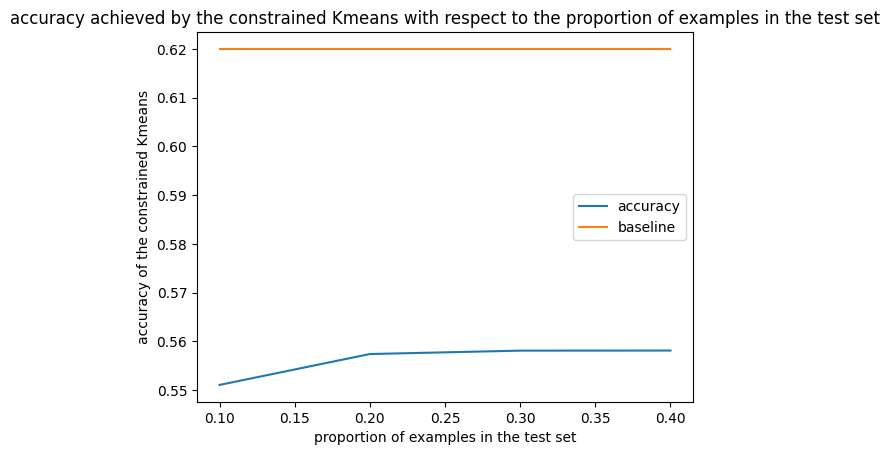

In [57]:
print("mean baseline over all the examples with five additional files of unlabeled data: ", "{:.3f}".format(mean_baseline))

# Plot the accuracies of the constrained Kmeans:
accuracies = []
# proportion of the test size: smaller proportion = more examples to train the Kmeans.
for proportion in np.arange(0.1, 0.5, 0.1):  # 0.1, 0.2... to 0.9
  accuracies.append(get_accuracy_constr_kmeans_NA(proportion, examples_NA_five,nb_splits=3))

plt.plot(np.arange(0.1, 0.5, 0.1), accuracies, label='accuracy')
plt.plot(np.arange(0.1, 0.5, 0.1), [get_baseline(examples) for _ in np.arange(0.1, 0.5, 0.1)], label='baseline')
plt.legend()
plt.xlabel("proportion of examples in the test set")
plt.ylabel("accuracy of the constrained Kmeans")
plt.title("accuracy achieved by the constrained Kmeans with respect to the proportion of examples in the test set")

Comparing the accuracies for different ambiguous lemmas when adding **five** files to the labeled data:

In [58]:
get_accuracy_NA_lemma('estimer',examples_NA_five,5)
get_accuracy_NA_lemma('aggraver',examples_NA_five,5)
get_accuracy_NA_lemma('relancer',examples_NA_five,5)
get_accuracy_NA_lemma('confier',examples_NA_five,5)
get_accuracy_NA_lemma('disputer',examples_NA_five,5)

number of unlabled examples for 'estimer' in 5 file: 827
{0: ['0.92', '__ws_3_estimer__verb__'], 1: ['0.90', '__ws_1_estimer__verb__'], 2: ['0.75', '__ws_3_estimer__verb__']}
accuracy for estimer with 5 additional files of unlabeled data: 1.0

number of unlabled examples for 'aggraver' in 5 file: 74
{0: ['0.94', '__ws_1_aggraver__verb__'], 1: ['0.63', '__ws_1_aggraver__verb__']}
accuracy for aggraver with 5 additional files of unlabeled data: 0.8125

number of unlabled examples for 'relancer' in 5 file: 132
{0: ['0.82', '__ws_1_relancer__verb__'], 1: ['0.56', '__ws_6_relancer__verb__'], 2: ['0.50', '__ws_6_relancer__verb__']}
accuracy for relancer with 5 additional files of unlabeled data: 0.5625

number of unlabled examples for 'confier' in 5 file: 862
{0: ['1.00', ' __ws_2_confier__verb__'], 1: ['0.89', ' __ws_1_confier__verb__']}
accuracy for confier with 5 additional files of unlabeled data: 0.8125

number of unlabled examples for 'disputer' in 5 file: 1097
{0: ['1.00', '__ws_5_dis